In [1]:
import tensorflow as tf
import numpy as np

def get_Mtrx_and_H0(graph):
    H0 = tf.constant(graph['nodes_feature'])
    A = tf.SparseTensor(indices=np.transpose(graph["A"]),
                    values=np.array([v + 0 if index[0] != index[1] else 1
                                     for v, index in zip(graph["edges_feature"], np.transpose(graph["A"]))], dtype=np.float32), 
                    dense_shape=[max(graph["A"][0])+1, max(graph["A"][1])+1])
    d = tf.sparse.reduce_sum(A, axis=1)
    Mtrx = tf.SparseTensor(indices=np.transpose(graph["A"]),
                    values=np.array([v/d[index[0]] for index, v in zip(A.indices, A.values)], dtype=np.float32), 
                    dense_shape=[max(graph["A"][0])+1, max(graph["A"][1])+1])
    
    
    return Mtrx, tf.linalg.normalize(H0, axis=0)[0]

2024-10-10 19:10:43.270969: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 19:10:43.282400: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-10 19:10:43.295052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 19:10:43.320137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 19:10:43.325430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 19:10:43.343568: I tensorflow/core/platform/cpu_feature_gu

In [2]:
import json
with open("../dataset.json", "r") as f:
    dataset = json.load(f)['dataset']

In [3]:
print("DATASET INFO:")
print("count row:", len(dataset))
print("first:", dataset[0].keys())
print(f"\t A:", np.shape(dataset[0]["A"]))
print(f"\t nodes_feature:", np.shape(dataset[0]["nodes_feature"]))
print(f"\t edges_feature:", np.shape(dataset[0]["edges_feature"]))
print(f"\t true_edges:", np.shape(dataset[0]["true_edges"]))
print("end:", dataset[-1].keys())
print(f"\t A:", np.shape(dataset[-1]["A"]))
print(f"\t nodes_feature:", np.shape(dataset[-1]["nodes_feature"]))
print(f"\t edges_feature:", np.shape(dataset[-1]["edges_feature"]))
print(f"\t true_edges:", np.shape(dataset[-1]["true_edges"]))


DATASET INFO:
count row: 1557
first: dict_keys(['A', 'nodes_feature', 'edges_feature', 'true_edges'])
	 A: (2, 779)
	 nodes_feature: (385, 9)
	 edges_feature: (779,)
	 true_edges: (779,)
end: dict_keys(['A', 'nodes_feature', 'edges_feature', 'true_edges'])
	 A: (2, 2142)
	 nodes_feature: (1039, 9)
	 edges_feature: (2142,)
	 true_edges: (2142,)


# Третья модель

In [4]:

params = {
    "learning_rate": 0.01,
    "start_w": 0.1,
    "start_b": 1.0,
    "weight_loss": 0.95,
    "count_neuron_layer_1": 9,
    "count_neuron_layer_2": 12,
    "count_neuron_layer_end": 3,
    "epochs": 20,
     "count_batchs": 10,
}

In [29]:
def get_need_model(graph):
    M =max(graph["A"][0])+1
    N =max(graph["A"][1])+1
    indices_A = np.transpose(graph["A"])
    
    v = np.array(graph['nodes_feature'], dtype=np.float32)
    max_ = np.max(v, axis=0)
    min_ = np.min(v, axis=0)
    delta_ = max_- min_
    for i in range(len(v[0])):
        v[:, i] = (max_[i] - v[:, i])/delta_[i] if delta_[i] != 0 else v[:, i]
    H0 = tf.constant(v[:, :])
    A = tf.SparseTensor(indices=indices_A,
                    values=np.array([v + 0 if index[0] != index[1] else 1
                                     for v, index in zip(graph["edges_feature"], np.transpose(graph["A"]))], dtype=np.float32), 
                    dense_shape=[M, N])
    d = tf.sparse.reduce_sum(A, axis=1)
    Mtrx = tf.SparseTensor(indices=indices_A,
                    values=np.array([val/d[index[0]] for index, val in zip(A.indices, A.values)], dtype=np.float32), 
                    dense_shape=[M, N])
    
    s1 = tf.SparseTensor(indices=[[i, e0] for i, e0 in enumerate(graph["A"][0])],
                    values=np.ones_like(graph["A"][0], dtype=np.float32), 
                    dense_shape=[len(graph["A"][0]), max(graph["A"][0])+1])
    s2 = tf.SparseTensor(indices=[[i, e1] for i, e1 in enumerate(graph["A"][1])],
                    values=np.ones_like(graph["A"][0], dtype=np.float32), 
                    dense_shape=[len(graph["A"][0]), max(graph["A"][0])+1])
    return Mtrx, H0, s1, s2
    
def get_Mtrxs(graph):
    Mtrx, H0, s1, s2 = get_need_model(graph)
    true_edges = tf.constant(graph["true_edges"], dtype=tf.float32)
    return Mtrx, H0, s1, s2, true_edges

class MyEndLayer(tf.Module):
    def __call__(self, s1, s2, h):
        
        left_ = tf.sparse.sparse_dense_matmul(s1, h)
        right_ = tf.sparse.sparse_dense_matmul(s2, h)
        return 0.5*(1-tf.losses.cosine_similarity(left_ , right_))
        

class MyGraphConv(tf.Module):
    def __init__(self, input_size, outpu_size, activation_fun):
        self.W = tf.Variable(tf.random.normal(mean=params["start_w"], stddev=1.0, shape=[input_size, outpu_size]))
        self.B = tf.Variable(tf.random.normal(mean=params["start_b"], stddev=1.0, shape=[input_size, outpu_size]))
        self.activation = activation_fun

    def __call__(self, A, H0):
        H1 = self.activation(
            tf.matmul(tf.sparse.sparse_dense_matmul(A, H0), self.W) - tf.matmul(H0, self.B)
        )
        return H1

class GraphSegmenter3(tf.Module):
    def __init__(self):
        self.conv1 = MyGraphConv(params["count_neuron_layer_1"], 
                                 params["count_neuron_layer_2"], tf.nn.relu)
        self.conv2 = MyGraphConv(params["count_neuron_layer_2"], 
                                 params["count_neuron_layer_end"], tf.nn.relu)
        self.end_layer = MyEndLayer()

    @tf.function
    def __call__(self, A, H0, s1, s2):
        H1 = self.conv1(A, H0)
        H2 = self.conv2(A, H1)
        return self.end_layer(s1, s2, H2)

    
@tf.function        
def fun_loss(y_true, y_pred):
    return tf.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred)
    # return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=params["weight_loss"]))

@tf.function    
def my_loss(edges_pred, true_edges):
    return fun_loss(true_edges, edges_pred)

model3 = GraphSegmenter3()

In [6]:
graph = dataset[0]

In [7]:
A, H0, s1, s2, true_edges = get_Mtrxs(graph)

In [8]:
H_end = model3(A, H0, s1, s2)

In [9]:
my_loss(H_end, true_edges)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8502918>

In [10]:

params = {
    "learning_rate": 0.05,
    "start_w": 0.1,
    "start_b": 1.0,
    "weight_loss": 0.95,
    "count_neuron_layer_1": 9,
    "count_neuron_layer_2": 12,
    "count_neuron_layer_end": 3,
    "epochs": 10,
    "batch_size": 100,
}

In [47]:
def list_batchs(dataset, batch_size):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i:i+batch_size]

def train_one_step(model, batch, opt):
    my_loss_list = []
    count_matrix_var = len(model3.trainable_variables)
    dw_array = [[] for _ in range(count_matrix_var)]
    for i, graph in enumerate(batch):
        try:
            A, H0, s1, s2, true_edges = get_Mtrxs(graph)
            with tf.GradientTape() as tape:
                H_end = model(A, H0, s1, s2)
                loss = my_loss(H_end, true_edges)
                my_loss_list.append(loss)
                print(f"{(i+1)/len(batch)*100:.2f} % loss = {loss.numpy():.5f} {' '*30}",  end="\r")
            dW = tape.gradient(loss, model.trainable_variables)
            for i, dw in enumerate(dW):
                dw_array[i].append(dw)
        except:
            print(f"ERROR {i} - el in batch")
    dW = []
   
    for idw_array in dw_array:
        dW.append(tf.reduce_mean(idw_array, axis=0))
    opt.apply_gradients(zip(dW, model.trainable_variables))
    return np.mean(my_loss_list)


def test_NN(params, model, my_loss_list):
    EPOCHS = params["epochs"]
    opt = tf.optimizers.SGD(learning_rate=params["learning_rate"])
    for i in range(EPOCHS):
        print("="*10, f"EPOCH #{i+1}","="*10)
        for j, batch in enumerate(list_batchs(dataset, params["batch_size"])):
            loss_ = train_one_step(model, batch, opt)
            my_loss_list.append(loss_)
            print(f"Batch # {j}\t {loss_:.4f}", " "*20)
        
    return my_loss_list, model


# loss_array, model3 = test_NN(params)
# loss_array = test_NN(params)

In [12]:
# for par_1 in [0.0001, 0.001, 0.01]:
#     params["learning_rate"] = par_1
#     rez, _, _ = test_NN(params)
#     print("\n param: ", par_1, rez)

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex, to_rgb
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(to_rgb(c1))
    c2=np.array(to_rgb(c2))
    return to_hex((1-mix)*c1 + mix*c2)



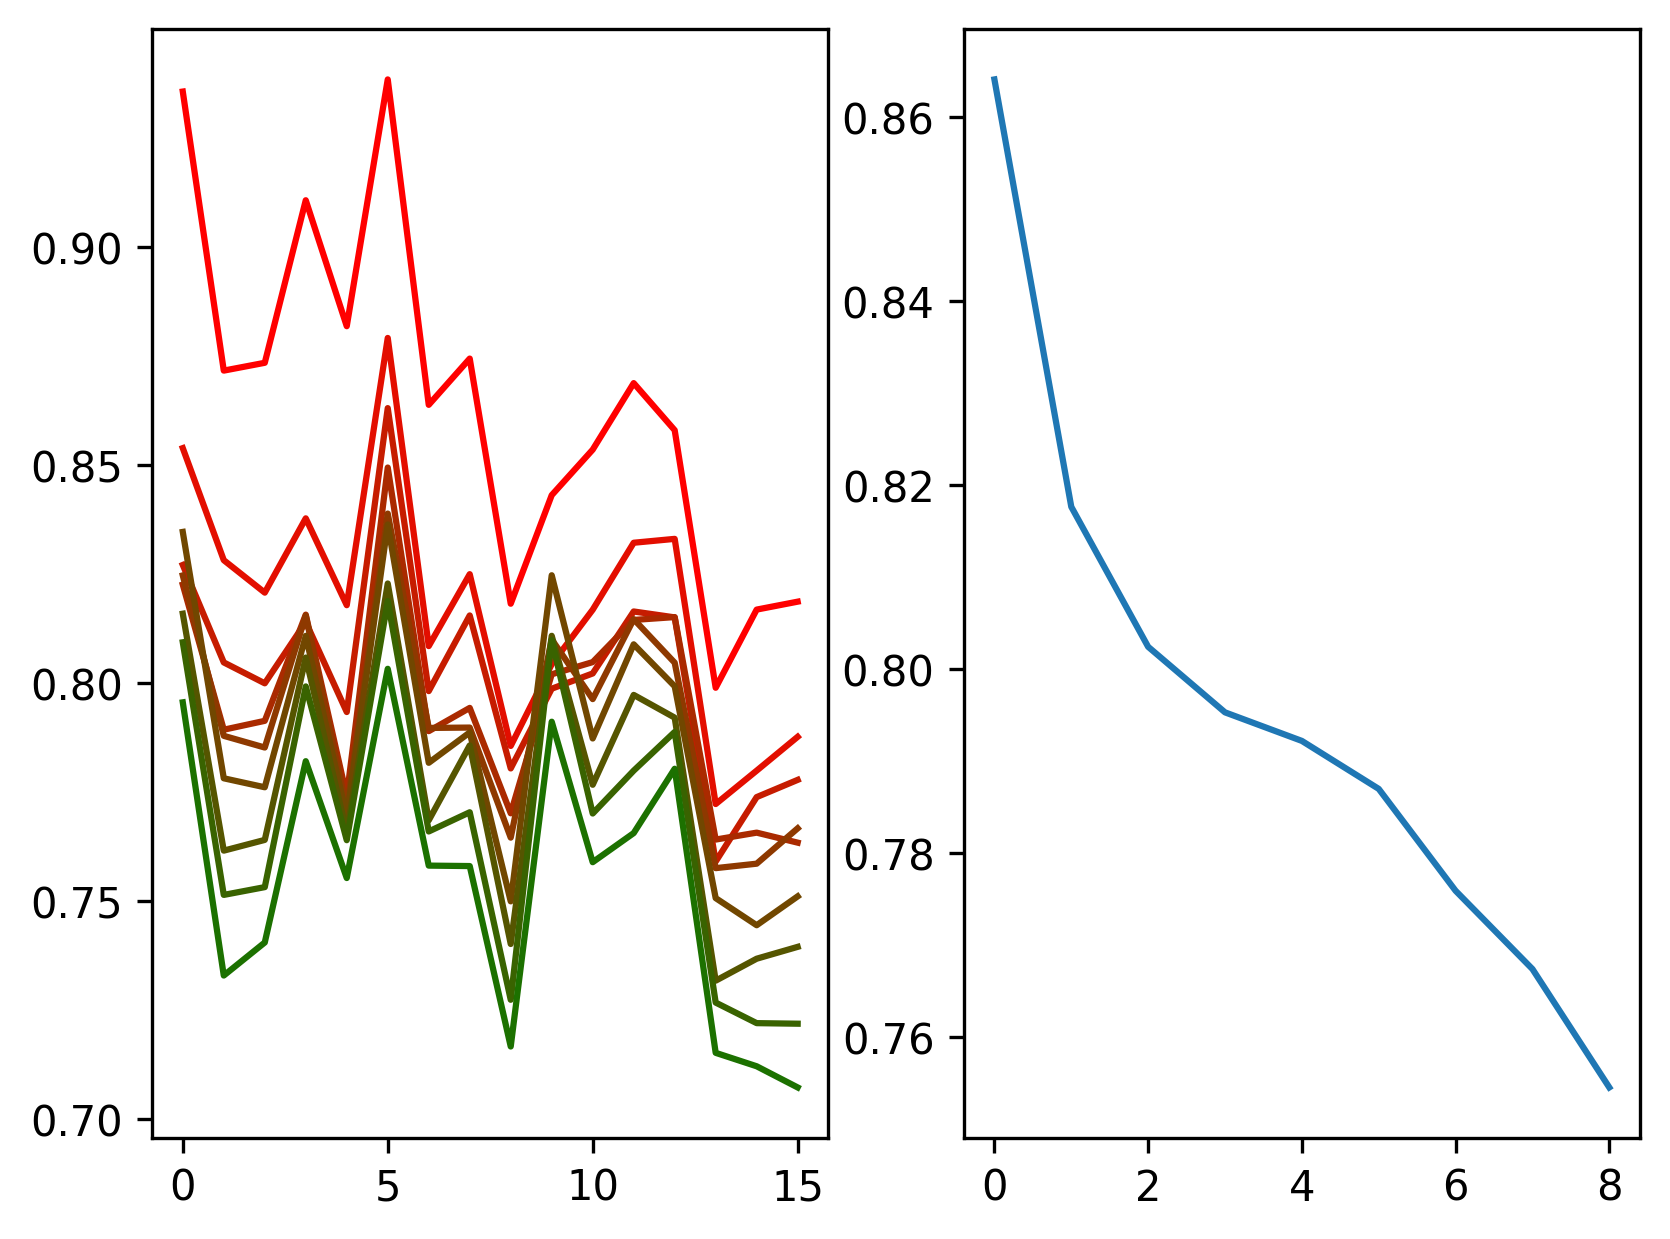

In [28]:
plt.figure(dpi=300)
plt.subplot(1,2,1)
for i in range(9):
    plt.plot(loss_array[i*16:(i+1)*16], colorFader("r", "g", i/9))
plt.subplot(1,2,2)
loss_array2 = [np.mean(loss_array[i*16:(i+1)*16]) for i in range(9)]
plt.plot(loss_array2)
# plt.ylim([1.0, 1.5])

In [18]:
tf.saved_model.save(name_model, "my_graph_model_2024-10-11")

INFO:tensorflow:Assets written to: my_graph_model_2024-10-11/assets


INFO:tensorflow:Assets written to: my_graph_model_2024-10-11/assets


In [30]:
load_model = tf.saved_model.load("my_graph_model_2024-10-11")

In [35]:
model3.conv1.W = load_model.conv1.W
model3.conv1.B = load_model.conv1.B
model3.conv2.W = load_model.conv2.W
model3.conv2.B = load_model.conv2.B

In [37]:
A, H0, s1,s2 = get_need_model(dataset[1501])
h1 = model3(A, H0, s1,s2)

In [50]:
with open('graph.json', 'r') as f:
    graph = json.load(f)
A, H0, s1,s2 = get_need_model(graph)
h1 = model3(A, H0, s1,s2)    

In [51]:
arr = h1.numpy()
arr.min(),np.median(arr), arr.max()

(0.5, 0.93724847, 1.0)

In [46]:
with open("graph_rez.json", "w") as f:
    json.dump({"h": h1.numpy().tolist()}, f)

In [51]:
v = graph['nodes_feature']
v=np.array(v)

In [48]:
loss_array, model3 = test_NN(params, model3, loss_array)

========== EPOCH #1 ==========


Batch # 0	 0.7879                                     
ERROR 25 - el in batch                               
Batch # 1	 0.7068                                     
ERROR 71 - el in batch                               
ERROR 88 - el in batch                               
Batch # 2	 0.7211                                     
ERROR 53 - el in batch                               
Batch # 3	 0.7657                                     
ERROR 49 - el in batch                               
ERROR 73 - el in batch                               
ERROR 78 - el in batch                               
ERROR 83 - el in batch                               
ERROR 88 - el in batch                               
Batch # 4	 0.7406                                     
ERROR 61 - el in batch                               
ERROR 80 - el in batch                               
ERROR 91 - el in batch                               
Batch # 5	 0.7869                                     
Batch # 6	 0.7355     

2024-10-11 13:11:38.456267: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [938,12] vs. [939,12]
	 [[{{node sub}}]]


ERROR 88 - el in batch                               
Batch # 4	 0.7106                                     
ERROR 61 - el in batch                               
ERROR 80 - el in batch                               
ERROR 91 - el in batch                               
Batch # 5	 0.6951                                     
Batch # 6	 0.6921                                     
ERROR 62 - el in batch                               
Batch # 7	 0.7236                                     
ERROR 9 - el in batch                               
ERROR 62 - el in batch                               
ERROR 67 - el in batch                               
ERROR 92 - el in batch                               
Batch # 8	 0.6486                                     
ERROR 45 - el in batch                               
Batch # 9	 0.7698                                     
ERROR 11 - el in batch                               
ERROR 52 - el in batch                               
ERROR 76 - el in batch 

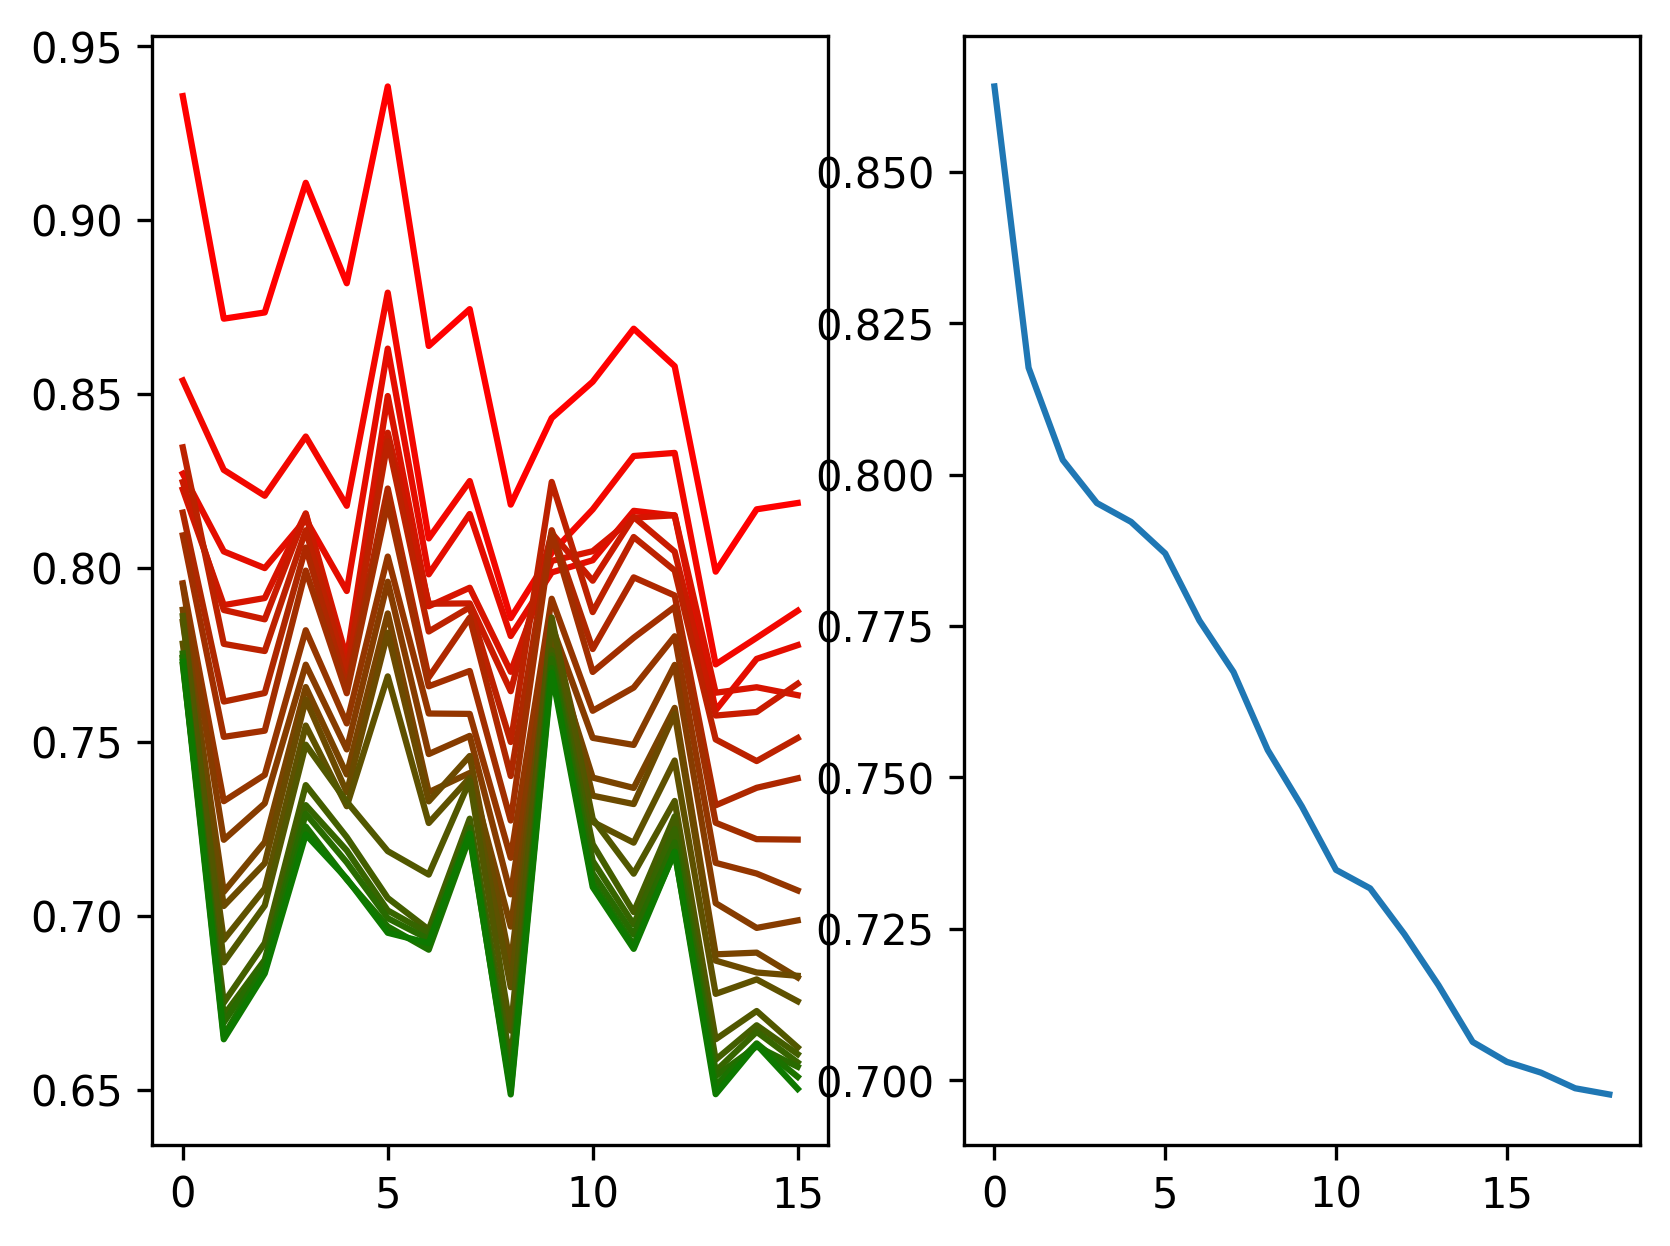

In [49]:
count_epoch = 20 - 1
plt.figure(dpi=300)
plt.subplot(1,2,1)
for i in range(count_epoch):
    plt.plot(loss_array[i*16:(i+1)*16], colorFader("r", "g", i/count_epoch))
plt.subplot(1,2,2)
loss_array2 = [np.mean(loss_array[i*16:(i+1)*16]) for i in range(count_epoch)]
plt.plot(loss_array2)
# plt.ylim([1.0, 1.5])

In [53]:
h1>0

<tf.Tensor: shape=(1314,), dtype=bool, numpy=array([ True,  True,  True, ...,  True,  True,  True])>

In [58]:
a = np.zeros_like(h1)
a[h1>0.51] = 1.0

In [60]:
np.unique(a)

array([0., 1.], dtype=float32)

# Модель мини версия

In [1]:
from utils import get_Mtrxs, classification_edges
from model import get_model

2024-10-11 16:24:35.496898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 16:24:35.500446: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 16:24:35.510320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 16:24:35.525351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 16:24:35.529815: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 16:24:35.542472: I tensorflow/core/platform/cpu_feature_gu

In [2]:
model = get_model()

2024-10-11 16:24:36.936868: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [64]:

params = {
    "learning_rate": 0.01,
    "epochs": 20,
    "count_batchs": 10,
}

def list_batchs(dataset, batch_size):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i:i+batch_size]

def train_one_step(model, batch, opt):
    my_loss_list = []
    count_matrix_var = len(model3.trainable_variables)
    dw_array = [[] for _ in range(count_matrix_var)]
    for i, graph in enumerate(batch):
        try:
            A, H0, s1, s2, true_edges = get_Mtrxs(graph)
            with tf.GradientTape() as tape:
                H_end = model(A, H0, s1, s2)
                loss = my_loss(H_end, true_edges)
                my_loss_list.append(loss)
                print(f"{(i+1)/len(batch)*100:.2f} % loss = {loss.numpy():.5f} {' '*30}",  end="\r")
            dW = tape.gradient(loss, model.trainable_variables)
            for i, dw in enumerate(dW):
                dw_array[i].append(dw)
        except:
            pass
    dW = []
    for idw_array in dw_array:
        dW.append(tf.reduce_mean(idw_array, axis=0))
    opt.apply_gradients(zip(dW, model.trainable_variables))
    return np.mean(my_loss_list)


def train_model(params, model, path_save, save_frequency=5):  
    opt = tf.optimizers.SGD(learning_rate=params["learning_rate"])
    for i in range(params["epochs"]):
        print("="*10, f"EPOCH #{i+1}","="*10)
        for j, batch in enumerate(list_batchs(dataset, params["batch_size"])):
            loss_ = train_one_step(model, batch, opt)
            my_loss_list.append(loss_)
            print(f"Batch # {j}\t {loss_:.4f}", " "*20)
        
        if params["epochs"] % save_frequency = 0
            model.save(path_save+f"_{params["epochs"]//save_frequency}")
    model.save(path_save)

In [66]:
model3.variables

AttributeError: can't set attribute

In [8]:
with open('file.txt', 'a') as f: 
    f.write("log4\n")